In [1]:
%load_ext autoreload
%autoreload 2

### data loading and preparation

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0

In [3]:
adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad')

In [3]:
proj_name = "cel_packerN2"
file_name = "cel_packerN2"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=10000, subset=False)
sc.tl.pca(adata, n_comps=300, svd_solver='arpack', use_highly_variable=True)
adata = adata[:, adata.var.highly_variable].copy()

In [ ]:
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed.h5ad'}")

✅ Preprocessed data saved to ../data/cel_packerN2/cel_packerN2_preprocessed.h5ad


### Create jobs

In [21]:
concord_args = {
        'batch_size':64, # Batch size for training, adjust as needed
        'encoder_dims':[1000], # Encoder dimensions, recommended to be larger than latent_dim
        'augmentation_mask_prob': 0.3, # Probability of masking features, recommended to be between 0.2 and 0.5
        'clr_temperature': 0.3, # Temperature for contrastive loss, recommended to be between 0.1 and 0.5
        'sampler_knn': 1000, # Size of neighbohood for intra-neighborhood sampling
        'n_epochs': 15, # Number of epochs for training, adjust as needed
        'save_dir': '../'+str(save_dir) # Directory to save the model and results
    }

In [22]:
import subprocess, json
methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
output_dir = '../jobs'
device = 'auto'
conda_env = 'cellpath'
batch_key = 'batch'
state_key = 'None'
latent_dim = '300'  # Adjust as needed, but should match the encoder_dims in concord_args
subprocess.run([
    "python", "./generate_py_sh_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed.h5ad",
    "--methods", *methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env,
    "--runtime", "02:00:00",
    "--concord_kwargs", json.dumps(concord_args)
])


✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_scvi.py
✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_scvi.sh

✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_harmony.py
✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_harmony.sh

✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_scanorama.py
✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_scanorama.sh

✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_liger.py
✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_liger.sh

✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_unintegrated.py
✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_unintegrated.sh

✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_concord_hcl.py
✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_concord_hcl.sh

✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_concord_knn.py
✅ Generated: benchmark_cel_packerN2/benchmark_cel_packerN2_concord_k

CompletedProcess(args=['python', './generate_py_sh_jobs.py', '--proj_name', 'cel_packerN2', '--adata_filename', 'cel_packerN2_preprocessed.h5ad', '--methods', 'scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive', '--batch_key', 'batch', '--state_key', 'None', '--latent_dim', '300', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'cellpath', '--runtime', '02:00:00', '--concord_kwargs', '{"batch_size": 64, "encoder_dims": [1000], "augmentation_mask_prob": 0.3, "clr_temperature": 0.3, "sampler_knn": 1000, "n_epochs": 15, "save_dir": "../../save/cel_packerN2"}'], returncode=0)

In [18]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_cel_packerN2/submit_all_cel_packerN2.sh” to queue every job.


### Collect results

In [ ]:
methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad') # Load the log normalized but unfiltered adata
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
print(f"✅ Embeddings saved to {save_dir / f'obsm_{file_suffix}.h5'}")
final_path = data_dir / f"{file_name}_final.h5ad"
adata.write_h5ad(final_path)
print(f"✅ Final AnnData saved to: {final_path}")

✅ obsm['X_scvi'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP']
✅ obsm['scvi_UMAP'] computed
✅ obsm['X_harmony'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP']
✅ obsm['harmony_UMAP'] computed
✅ obsm['X_scanorama'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP']
✅ obsm['scanorama_UMAP'] computed
✅ obsm['X_liger'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['liger_UMAP']
✅ obsm['liger_UMAP'] computed
✅ obsm['X_unintegrated'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['unintegrated_UMAP']
✅ obsm['unintegrated_UMAP'] computed
✅ obsm['X_concord_hcl'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP']
✅ obsm['concord_hcl_UMAP'] computed
✅ obsm['X_concord_knn'] loaded
Concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP']
✅ obsm['concord_knn_UMAP'] computed
✅ obsm['X_contrastive'] loaded
Concord - INFO - UMAP embedding stored in a

In [ ]:
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='cel')
print(f"Saved viscello to {data_dir / f'cello_{proj_name}_{file_suffix}'}")

✅ Benchmark summary saved to: ../save/cel_packerN2/benchmark_summary_Jun27-2154.tsv


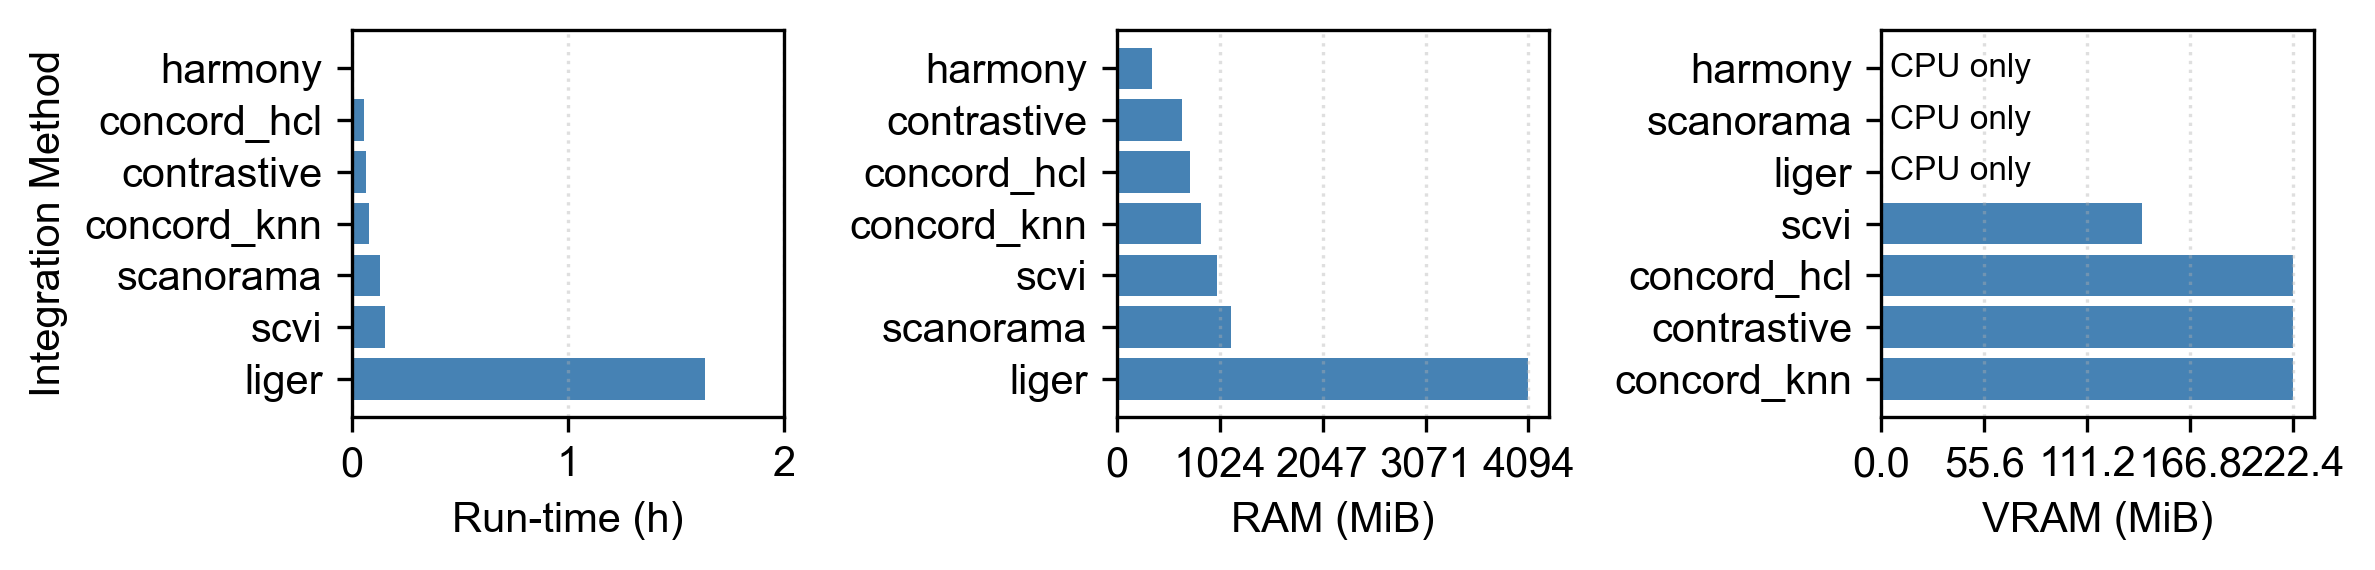

In [15]:
from benchmark_utils import collect_benchmark_logs
methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
bench_df = collect_benchmark_logs("cel_packerN2", methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")
